In [1]:
#라이브러리 임포트
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import cv2
import tensorflow as tf
from tensorflow.keras import layers, optimizers
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [2]:
#이미지 사이즈 조절용 함수
def read_and_preprocess(img_path):
    img = cv2.imread(img_path, cv2.IMREAD_COLOR) # reading the image
    img = cv2.resize(img, (256, 256)) # resizing it (I just like it to be powers of 2)
    img = np.array(img, dtype='float32') # convert its datatype so that it could be normalized
    img = img/255 # normalization (now every pixel is in the range of 0 and 1)
    return img


In [3]:
#이미지 및 레이블 관리
X_train = []
y_train = []

train_path = "./train/"

In [4]:
#이미지와 레이블 불러오기
for folder in os.scandir(train_path):
    for entry in os.scandir(train_path + folder.name):

        X_train.append(read_and_preprocess(train_path + folder.name + '/' + entry.name))
        
        if folder.name[0]=='C':
            y_train.append(0)
        elif folder.name[0]=='V':
            y_train.append(1)
        else:
            y_train.append(2)

In [5]:
#X_train내용 확인
X_train = np.array(X_train)
X_train.shape

(251, 256, 256, 3)

In [6]:
#y_train내용 확인
y_train = np.array(y_train)
y_train.shape

(251,)

<BarContainer object of 3 artists>

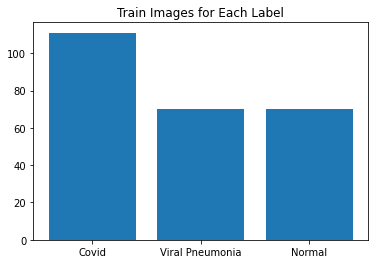

In [7]:
#레이블별 데이터 갯수 시각화
covid_count = len(y_train[y_train==0])
pneumonia_count = len(y_train[y_train==1])
normal_count = len(y_train[y_train==2])

plt.title("Train Images for Each Label")
plt.bar(["Covid", "Viral Pneumonia", "Normal"],[covid_count, pneumonia_count, normal_count])

In [8]:
#데이터 증대를 위해 영상 좌우반전
X_aug = []
y_aug = []

for i in range(0, len(y_train)):
    X_new = np.fliplr(X_train[i])
    X_aug.append(X_new)
    y_aug.append(y_train[i])

X_aug = np.array(X_aug)
y_aug = np.array(y_aug)

In [9]:
#증배된 데이터 확인
X_train = np.append(X_train, X_aug, axis=0)
X_train.shape

(502, 256, 256, 3)

In [10]:
y_train = np.append(y_train, y_aug, axis=0)
y_train.shape

(502,)

In [11]:
#검증 이미지 불러오기
X_val = []
y_val = []

val_path = './test/'

for folder in os.scandir(val_path):
    for entry in os.scandir(val_path + folder.name):

        X_val.append(read_and_preprocess(val_path + folder.name + '/' + entry.name))
        
        if folder.name[0]=='C':
            y_val.append(0)
        elif folder.name[0]=='V':
            y_val.append(1)
        else:
            y_val.append(2)
            
X_val = np.array(X_val)
y_val = np.array(y_val)

In [12]:
X_val.shape

(66, 256, 256, 3)

<BarContainer object of 3 artists>

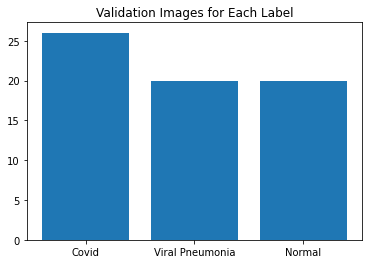

In [13]:
covid_count = len(y_val[y_val==0])
pneumonia_count = len(y_val[y_val==1])
normal_count = len(y_val[y_val==2])

plt.title("Validation Images for Each Label")
plt.bar(["Covid", "Viral Pneumonia", "Normal"],[covid_count, pneumonia_count, normal_count])

In [14]:
#전이학습을 위한 모델 생성
basemodel = VGG16(weights = 'imagenet', include_top = False, input_tensor = Input(shape=(256, 256, 3)))

58892288/58889256 [==============================] - 5s 0us/step


In [15]:
#모델 레이어 확인
basemodel.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 64, 64, 128)       0     

In [16]:
#베이스모델 가중치 변경 금지
for layer in basemodel.layers:
  layers.trainable = False

In [17]:
#베이스모델 뒤에 추가레이어 쌓기
headmodel = basemodel.output
headmodel = Flatten(name= 'flatten')(headmodel)
headmodel = Dense(3, activation = 'softmax')(headmodel)

model = Model(inputs = basemodel.input, outputs = headmodel)

In [18]:
#쌓은모델 레이어 확인
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 64, 64, 128)       0     

In [19]:
#옵티마이저 선언
opt = optimizers.Adam(learning_rate=0.0001)

In [20]:
#모델 컴파일
model.compile(loss = 'sparse_categorical_crossentropy', optimizer=opt, metrics= ["accuracy"])

In [21]:
#조기종료 설정
earlystopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)

In [22]:
#모델 자동저장 설정
checkpointer = ModelCheckpoint(filepath="covid_classifier_weights.h5", verbose=1, save_best_only=True)

In [23]:
#모댈 학습 시작
history = model.fit(X_train, y_train, epochs = 100, validation_data=(X_val, y_val), batch_size=16, shuffle=True, callbacks=[earlystopping, checkpointer])

Epoch 1/100
 7/32 [=====>........................] - ETA: 4:50 - loss: 0.8512 - accuracy: 0.6250

KeyboardInterrupt: 

In [ ]:
#학습곡선 시각화
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
#모델구성 json으로 저장
model_json = model.to_json()
with open("covid_classifier_model.json","w") as json_file:
  json_file.write(model_json)

In [24]:
#저장한 모델 평가를 위한 모델 불러오기
with open('covid_classifier_model.json', 'r') as json_file:
    json_savedModel= json_file.read()

model = tf.keras.models.model_from_json(json_savedModel)
model.load_weights('covid_classifier_weights.h5')
model.compile(loss = 'sparse_categorical_crossentropy', optimizer=opt, metrics= ["accuracy"])

FileNotFoundError: [Errno 2] No such file or directory: 'covid_classifier_model.json'

In [25]:
predictions = model.predict(X_val)


KeyboardInterrupt: 

In [ ]:
predictions.shape

In [ ]:
#모댈 예측 시작
predict = []

for i in predictions:
  predict.append(np.argmax(i))

predict = np.asarray(predict)

In [ ]:
#모델 정확도 확인
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(y_val, predict)
accuracy

from sklearn.metrics import classification_report

report = classification_report(y_val, predict)
print(report)

In [ ]:
#혼동행렬 확인
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_val, predict)
plt.figure(figsize = (7,7))
sns.heatmap(cm, annot=True, cmap='Blues')